In [2]:
import pandas as pd
import time
import gc
import sklearn
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
import xgboost as xgb
from scipy.stats import uniform
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform



#### Unificamos los datos para evaluar correlacion de variables ####

In [21]:
data0 = pd.read_csv('/Users/ionikullock/Desktop/UTDT-Tecnología Digital/TD VI/Trabajo práctico 2/Datos/ctr_15.csv')  #  dataset
data1 = pd.read_csv('/Users/ionikullock/Desktop/UTDT-Tecnología Digital/TD VI/Trabajo práctico 2/Datos/ctr_16.csv')  #  dataset
data2= pd.read_csv('/Users/ionikullock/Desktop/UTDT-Tecnología Digital/TD VI/Trabajo práctico 2/Datos/ctr_17.csv')   #  dataset
data3 = pd.read_csv('/Users/ionikullock/Desktop/UTDT-Tecnología Digital/TD VI/Trabajo práctico 2/Datos/ctr_18.csv')  #  dataset
data4 = pd.read_csv('/Users/ionikullock/Desktop/UTDT-Tecnología Digital/TD VI/Trabajo práctico 2/Datos/ctr_19.csv')  #  dataset
data5 = pd.read_csv('/Users/ionikullock/Desktop/UTDT-Tecnología Digital/TD VI/Trabajo práctico 2/Datos/ctr_20.csv')  #  dataset
data6 = pd.read_csv('/Users/ionikullock/Desktop/UTDT-Tecnología Digital/TD VI/Trabajo práctico 2/Datos/ctr_21.csv')  #  dataset

data = pd.concat([data0,data1,data2,data3,data4,data5,data6])
print("Tamaño del conjunto ", data.shape)

Tamaño del conjunto  (8644592, 52)


#### Hallamos la matriz de correlación y vemos que variables son más significativas ####


Correlación de cada columna numérica con 'Label':
Label               1.000000
creative_height     0.096497
auction_bidfloor    0.090016
creative_width      0.038760
timezone_offset     0.023882
auction_time        0.017966
auction_age        -0.008386
Name: Label, dtype: float64


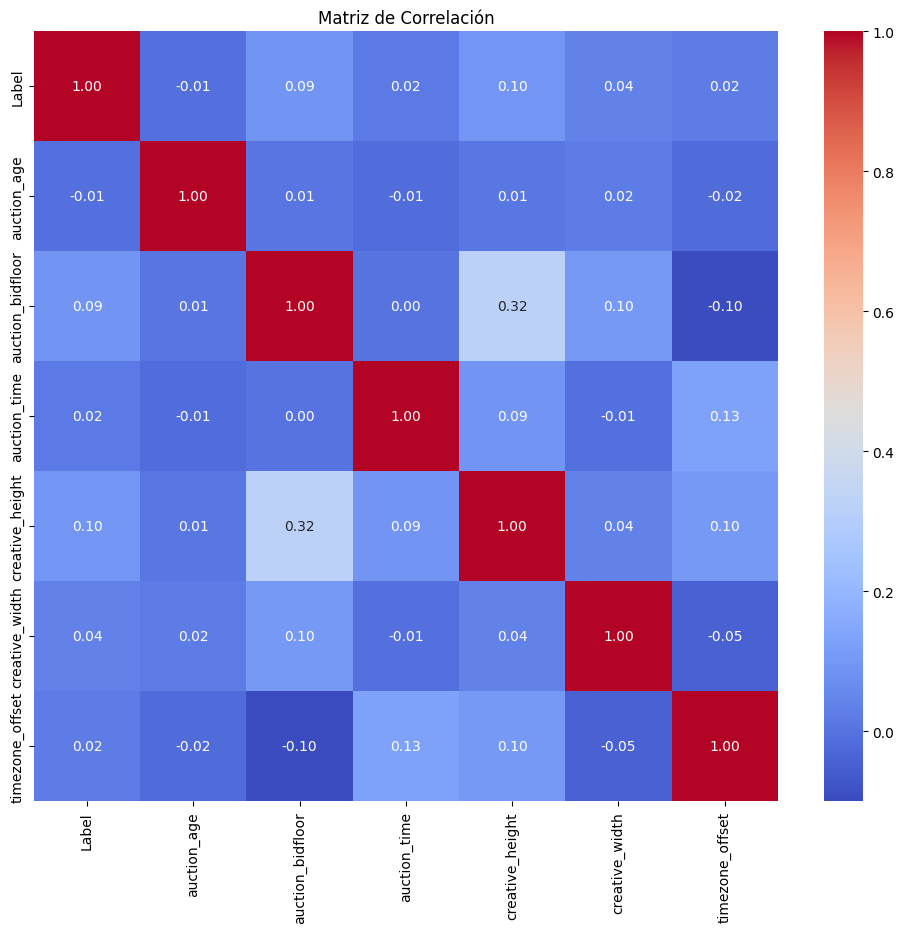

In [22]:
data_numerica = data.select_dtypes(include=[np.number])

# Asegurarse de que la columna 'label' esté en el DataFrame
if 'Label' not in data_numerica.columns:
    raise ValueError("La columna 'Label' no se encuentra en el DataFrame")

# Calcular la correlación entre cada columna numérica y la columna 'label'
correlaciones = data_numerica.corr()['Label'].sort_values(ascending=False)

# Imprimir las correlaciones
print("\nCorrelación de cada columna numérica con 'Label':")
print(correlaciones)

# Calcular la matriz de correlación
correlation_matrix = data_numerica.corr()

# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

#### Veamos ahora para las variables categoricas ####

In [23]:
non_numeric_data = data.select_dtypes(include=['object'])
non_numeric_data = non_numeric_data.fillna('missing')
label_encoders = {}

for column in non_numeric_data.columns:
    le = LabelEncoder()
    non_numeric_data[column] = le.fit_transform(non_numeric_data[column].astype(str))
    label_encoders[column] = le

# Calcular la Información Mutua
mi_scores = mutual_info_classif(non_numeric_data, data['Label'], discrete_features=True)

# Crear un DataFrame para los resultados
mi_scores_df = pd.DataFrame({'Feature': non_numeric_data.columns, 'Mutual Information': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information', ascending=False)
print(mi_scores_df)

# Identificar las características menos informativas
least_informative_features = mi_scores_df.nsmallest(38, 'Mutual Information')['Feature']
print("Características menos informativas:")
print(least_informative_features)


KeyboardInterrupt: 

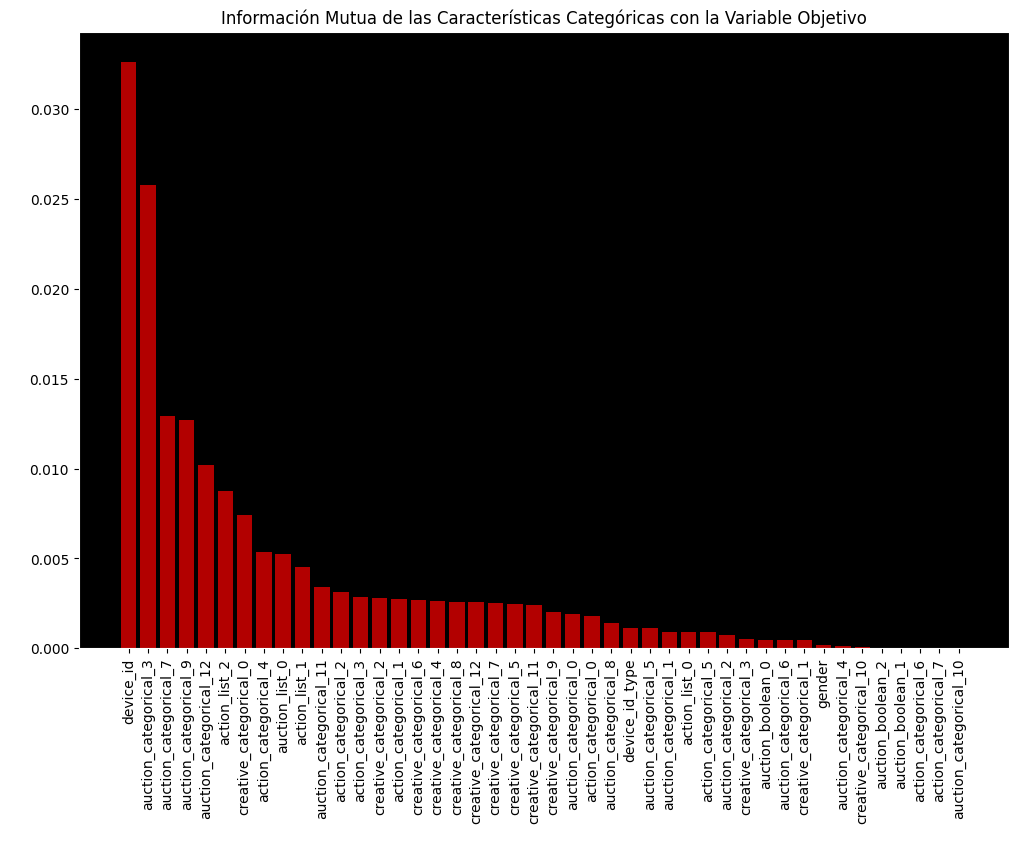

In [23]:
# Gráfico de barras verticales
plt.figure(figsize=(12, 8))
plt.bar(mi_scores_df['Feature'], mi_scores_df['Mutual Information'], color='red', alpha=0.7)
plt.xticks(rotation=90)  # Rotar etiquetas del eje x para mejor visibilidad
plt.xlabel('Características')
plt.ylabel('Información Mutua')
plt.title('Información Mutua de las Características Categóricas con la Variable Objetivo')
plt.gca().set_facecolor('black')  # Fondo negro del gráfico
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().yaxis.label.set_color('white')
plt.gca().xaxis.label.set_color('white')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.show()

#### Veamos el fenomeno de device_id ####

In [25]:
device_stats = data.groupby('device_id')['Label'].agg(['mean', 'std', 'count'])
print(device_stats.head())
print(device_stats['mean'].describe())

           mean  std  count
device_id                  
0000002d    0.0  0.0      4
00001140    0.0  NaN      1
000013cc    0.0  0.0      2
0000242a    0.0  NaN      1
0000300b    0.0  0.0      2
count    979633.000000
mean          0.018996
std           0.105549
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: mean, dtype: float64


#### interpretación ####

	•	device_id con poco o ningún Label igual a 1:
Los device_ids con una media de 0.0 y sin variación (desviación estándar de 0.0) indican que todos los Label para esos device_id son 0. Esto puede sugerir que estos identificadores están asociados con categorías que no tienen casos positivos (1).
	•	device_id con NaN en la desviación estándar:
Los device_ids con NaN en la desviación estándar tienen solo una entrada en esos grupos, por lo que no hay variación para calcular la desviación estándar. Estos pueden ser casos raros o inusuales.
	•	Correlación Observada:
La alta correlación observada con device_id podría deberse a la estructura de los datos, donde ciertos identificadores están sobre-representados en casos de Label igual a 1. Esto puede ocurrir si algunos device_ids están asociados a características o grupos específicos que tienen una alta probabilidad de un Label positivo.

#### Eliminamos las columnas que no son significativas para predecir Label ####

In [11]:
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information', ascending=False)

# Mostrar el DataFrame para verificar
print(mi_scores_df)

# Eliminar las N características menos importantes (por ejemplo, las últimas 5)
N = 17  # Número de características a eliminar
least_informative_features = mi_scores_df.tail(N)['Feature']  # Selecciona las últimas N características

# Eliminar las columnas menos informativas del dataset original
data = data.drop(least_informative_features, axis=1)


                    Feature  Mutual Information
41                device_id        3.266114e-02
20    auction_categorical_3        2.576275e-02
24    auction_categorical_7        1.292184e-02
26    auction_categorical_9        1.271106e-02
18   auction_categorical_12        1.020239e-02
10            action_list_2        8.754003e-03
28   creative_categorical_0        7.409940e-03
4      action_categorical_4        5.381530e-03
27           auction_list_0        5.225138e-03
9             action_list_1        4.534304e-03
17   auction_categorical_11        3.410883e-03
2      action_categorical_2        3.144108e-03
3      action_categorical_3        2.824880e-03
33   creative_categorical_2        2.790357e-03
1      action_categorical_1        2.752061e-03
37   creative_categorical_6        2.662849e-03
35   creative_categorical_4        2.607352e-03
39   creative_categorical_8        2.599472e-03
32  creative_categorical_12        2.548379e-03
38   creative_categorical_7        2.522

In [31]:
print("Parámetros restantes después de eliminar las características menos importantes:")

columnas_restantes = data.columns.tolist()
for columna in columnas_restantes:
    print(columna)

Parámetros restantes después de eliminar las características menos importantes:
Label
action_categorical_0
action_categorical_1
action_categorical_2
action_categorical_3
action_categorical_4
action_list_1
action_list_2
auction_age
auction_bidfloor
auction_categorical_0
auction_categorical_11
auction_categorical_12
auction_categorical_3
auction_categorical_7
auction_categorical_8
auction_categorical_9
auction_list_0
auction_time
creative_categorical_0
creative_categorical_11
creative_categorical_12
creative_categorical_2
creative_categorical_4
creative_categorical_5
creative_categorical_6
creative_categorical_7
creative_categorical_8
creative_categorical_9
creative_height
creative_width
device_id
device_id_type
has_video
timezone_offset


In [12]:
unique_device_ids = data['device_id'].unique()

# Para mostrar los valores únicos
print(len(unique_device_ids))
print("Tamaño del conjunto ", data.shape)

979633
Tamaño del conjunto  (8644592, 35)


Eliminamos Device_ID


In [13]:
data.drop(columns=['device_id'], inplace=True)

#### Realizamos una reducción al 10% de los datos y guardamos el nuevo dataset como data_reducido ####

In [5]:
data_reducido, _ = train_test_split(data, train_size=0.1, random_state=123)
print("Tamaño del conjunto ", data_reducido.shape)
data_reducido.to_csv('data_reducido.csv', index=False)

NameError: name 'data' is not defined

In [14]:
data_reducido = pd.read_csv("/Users/ionikullock/Desktop/UTDT-Tecnología Digital/TD VI/Trabajo práctico 2/Datos/data_reducido.csv")
data_test = pd.read_csv("/Users/ionikullock/Desktop/UTDT-Tecnología Digital/TD VI/Trabajo práctico 2/Datos/ctr_test.csv")

columns_to_remove = ['device_id','action_list_1', 'action_list_2', 'action_categorical_0', 'auction_list_0', 'action_categorical_2', 'action_categorical_4', 'auction_categorical_0', 'auction_categorical_11', 'auction_categorical_3', 'creative_categorical_0', 'auction_categorical_7']

# Eliminar columnas del DataFrame original
data_reducido = data_reducido.drop(columns=columns_to_remove, errors='ignore')
data_test = data_reducido.drop(columns=columns_to_remove, errors='ignore')

print(f"Columnas eliminadas: {columns_to_remove}")
print(f"Tamaño del DataFrame después de la eliminación: {data_reducido.shape}")

Columnas eliminadas: ['device_id', 'action_list_1', 'action_list_2', 'action_categorical_0', 'auction_list_0', 'action_categorical_2', 'action_categorical_4', 'auction_categorical_0', 'auction_categorical_11', 'auction_categorical_3', 'creative_categorical_0', 'auction_categorical_7']
Tamaño del DataFrame después de la eliminación: (864459, 23)


In [15]:
missing_counts = data_reducido.isnull().sum()

# Filtrar columnas con valores faltantes y ordenar por cantidad
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

print("Columnas con más valores faltantes:")
print(missing_counts)

# Filtrar columnas con más de 140,000 valores faltantes
columns_to_drop = missing_counts[missing_counts > 140000].index

# Eliminar las columnas del DataFrame
data_reducido_cleaned = data_reducido.drop(columns=columns_to_drop)

missing_counts = data_reducido.isnull().sum()

# Filtrar columnas con más de 140,000 valores faltantes
columns_to_drop = missing_counts[missing_counts > 140000].index

# Eliminar las columnas del DataFrame
data_reducido_cleaned = data_reducido.drop(columns=columns_to_drop)
data_test = data_test.drop(columns=columns_to_drop)


# Mostrar resultados
print(f"Columnas eliminadas: {columns_to_drop.tolist()}")
print(f"Tamaño del DataFrame después de la eliminación: {data_reducido_cleaned.shape}")
import pandas as pd

# Selecciona las columnas categóricas
categorical_columns = data_reducido_cleaned.select_dtypes(include=['object']).columns

# Obtener una lista de todas las categorías en cada columna categórica
categories_dict = {}
for column in categorical_columns:
    categories_dict[column] = data_reducido_cleaned[column].unique()

# Imprimir las categorías por columna
for column, categories in categories_dict.items():
    print(f"Columna: {column}")
    print(f"Categorías: {categories}")
    print(f"Número de categorías: {len(categories)}")
    print()

Columnas con más valores faltantes:
creative_categorical_7     741392
creative_categorical_6     740705
creative_categorical_12    738925
creative_categorical_5     731972
creative_categorical_2     728232
auction_age                689561
auction_categorical_9      254808
auction_categorical_12     184869
creative_height            132614
creative_width             132614
creative_categorical_4     132578
creative_categorical_9      10275
timezone_offset               833
dtype: int64
Columnas eliminadas: ['auction_age', 'auction_categorical_12', 'auction_categorical_9', 'creative_categorical_12', 'creative_categorical_2', 'creative_categorical_5', 'creative_categorical_6', 'creative_categorical_7']
Tamaño del DataFrame después de la eliminación: (864459, 15)
Columna: action_categorical_1
Categorías: ['e220fce9' 'dc24b79b' '3074db21' 'f71d2f9b' '6d1ca31b' 'd9eb38d8'
 'f4cd321d' '0d132da2' 'ac0f362d' '62f19448' 'e709bbc0' 'df5eb4dc'
 '11fe6f26' '49bef539']
Número de categorías: 14

Col

In [16]:
print("Forma del DataFrame original:", data_reducido_cleaned.shape)
print("Primeras filas del DataFrame original:")
print(data_reducido_cleaned.head())

# Función para aplicar la codificación one-hot en partes
def apply_one_hot_encoding(df, columns):
    for col in columns:
        print(f"Codificando columna: {col}")
        df = pd.get_dummies(df, columns=[col], sparse=True, dummy_na=False, dtype=int)
        print(f"Forma después de codificar {col}: {df.shape}")
    return df

# Lista de columnas a codificar
columns_to_encode = [
    'action_categorical_1', 'action_categorical_3', 
    'auction_categorical_8', 'creative_categorical_11', 'creative_categorical_4', 'creative_categorical_8', 
    'creative_categorical_9', 'device_id_type'
]

# Aplicar codificación one-hot en partes y monitorear el progreso
data_encoded = apply_one_hot_encoding(data_reducido_cleaned, columns_to_encode)
data_encoded_test = apply_one_hot_encoding(data_test, columns_to_encode)


Forma del DataFrame original: (864459, 15)
Primeras filas del DataFrame original:
   Label action_categorical_1 action_categorical_3  auction_bidfloor  \
0      0             e220fce9             e9c266f7          0.061728   
1      0             dc24b79b             7ce4e1a3          1.234568   
2      0             3074db21             62c903fc          0.790000   
3      0             dc24b79b             7ce4e1a3          0.299000   
4      0             3074db21             62c903fc          0.070000   

  auction_categorical_8  auction_time creative_categorical_11  \
0              856f1b75  1.516053e+09                65dcab89   
1              856f1b75  1.516144e+09                65dcab89   
2              198c733d  1.516100e+09                65dcab89   
3              e361d5bc  1.516246e+09                65dcab89   
4              198c733d  1.516135e+09                65dcab89   

  creative_categorical_4 creative_categorical_8 creative_categorical_9  \
0               150d

#### Ahora separamos el conjunto de datos reducido en train al 70%, test al 15% y validation al 15% 

In [17]:
train_data, temp_data = train_test_split(data_encoded, train_size=0.7, random_state=123)
test_data, validation_data = train_test_split(temp_data, test_size=0.5, random_state=123)
print("Tamaño del conjunto Train: (70%) ", train_data.shape)
print("Tamaño del conjunto Test: (15%)", test_data.shape)
print("Tamaño del conjunto Train: (15%)", validation_data.shape)


Tamaño del conjunto Train: (70%)  (605121, 63)
Tamaño del conjunto Test: (15%) (129669, 63)
Tamaño del conjunto Train: (15%) (129669, 63)


#### Separamos la variable "Label" que intentamos predecir

In [18]:
# Separar características y etiquetas
X_train = train_data.drop('Label', axis=1)  # Asegúrate de reemplazar 'target' con el nombre de tu variable objetivo
y_train = train_data['Label']

X_test = test_data.drop('Label', axis=1)
y_test = test_data['Label']

X_val = validation_data.drop('Label', axis=1)
y_val = validation_data['Label']

print("Tamaño del conjunto X_train:", X_train.shape)
print("Tamaño del conjunto X_test:", X_test.shape)
print("Tamaño del conjunto X_val:", X_val.shape)

Tamaño del conjunto X_train: (605121, 62)
Tamaño del conjunto X_test: (129669, 62)
Tamaño del conjunto X_val: (129669, 62)


#### Entrenamos el arbol de decision basico

Utilizamos One Hot Encoding para trabajar con las variables categoricas

In [19]:
for column in data_encoded.columns:
    try:
        # Intentar convertir la columna a tipo float
        data_encoded[column].astype(float)
    except ValueError as e:
        # Mostrar el error y la columna donde ocurrió
        print(f"Error en la columna: {column}")
        print(f"Detalles del error: {e}")

clf = DecisionTreeClassifier(random_state=123)
clf.fit(X_train, y_train)

y_val_prob = clf.predict_proba(X_val)[:, 1]  # Probabilidades de la clase positiva

# Calcular el AUC-ROC
auc_roc = roc_auc_score(y_val, y_val_prob)
print(f'AUC-ROC en el conjunto de validación: {auc_roc}')

# Predecir probabilidades en el conjunto de prueba
y_test_prob = clf.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

# Calcular el AUC-ROC en el conjunto de prueba
auc_roc_test = roc_auc_score(y_test, y_test_prob)
print(f'AUC-ROC en el conjunto de prueba: {auc_roc_test}')

/opt/anaconda3/envs/TD6/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


AUC-ROC en el conjunto de validación: 0.5402851444339505
AUC-ROC en el conjunto de prueba: 0.5516408741447224


/opt/anaconda3/envs/TD6/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/anaconda3/envs/TD6/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


# XGBOOST

In [20]:
random_state = 42
np.random.seed(random_state)
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic',
                            seed = random_state,
                            eval_metric = 'auc')

clf_xgb.fit(X_train, y_train, verbose = True, eval_set = [(X_val, y_val)])

/opt/anaconda3/envs/TD6/lib/python3.12/site-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


[0]	validation_0-auc:0.79339


/opt/anaconda3/envs/TD6/lib/python3.12/site-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


[1]	validation_0-auc:0.79803
[2]	validation_0-auc:0.79918
[3]	validation_0-auc:0.80231
[4]	validation_0-auc:0.80269
[5]	validation_0-auc:0.80401
[6]	validation_0-auc:0.81019
[7]	validation_0-auc:0.81205
[8]	validation_0-auc:0.81367
[9]	validation_0-auc:0.81496
[10]	validation_0-auc:0.81601
[11]	validation_0-auc:0.82020
[12]	validation_0-auc:0.82258
[13]	validation_0-auc:0.82316
[14]	validation_0-auc:0.82410
[15]	validation_0-auc:0.82415
[16]	validation_0-auc:0.82456
[17]	validation_0-auc:0.82408
[18]	validation_0-auc:0.82440
[19]	validation_0-auc:0.82462
[20]	validation_0-auc:0.82609
[21]	validation_0-auc:0.82631
[22]	validation_0-auc:0.82658
[23]	validation_0-auc:0.82684
[24]	validation_0-auc:0.82740
[25]	validation_0-auc:0.82722
[26]	validation_0-auc:0.82745
[27]	validation_0-auc:0.82751
[28]	validation_0-auc:0.82771
[29]	validation_0-auc:0.82753
[30]	validation_0-auc:0.82722
[31]	validation_0-auc:0.82747
[32]	validation_0-auc:0.82753
[33]	validation_0-auc:0.82811
[34]	validation_0-a

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [21]:

X_test_encoded, _ = data_encoded_test.align(X_train, join='left', axis=1, fill_value=0)

# Verificar que las columnas coincidan
print(X_test_encoded.head())
print(f"Tamaño de X_test_encoded: {X_test_encoded.shape}")

y_test_pred_xgb = clf_xgb.predict_proba(X_test_encoded)[:, 1]  # Probabilidad de la clase positiva

# Verificar las predicciones
print(y_test_pred_xgb[:10])  # Mostrar las primeras 10 predicciones


   Label  auction_bidfloor  auction_time  creative_height  creative_width  \
0      0          0.061728  1.516053e+09             50.0           320.0   
1      0          1.234568  1.516144e+09            480.0           320.0   
2      0          0.790000  1.516100e+09             50.0           320.0   
3      0          0.299000  1.516246e+09             50.0           320.0   
4      0          0.070000  1.516135e+09             50.0           320.0   

   has_video  timezone_offset  action_categorical_1_0d132da2  \
0      False              1.0                              0   
1      False              1.0                              0   
2      False              1.0                              0   
3      False              1.0                              0   
4      False              1.0                              0   

   action_categorical_1_11fe6f26  action_categorical_1_3074db21  ...  \
0                              0                              0  ...   
1       

/opt/anaconda3/envs/TD6/lib/python3.12/site-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


ValueError: feature_names mismatch: ['auction_bidfloor', 'auction_time', 'creative_height', 'creative_width', 'has_video', 'timezone_offset', 'action_categorical_1_0d132da2', 'action_categorical_1_11fe6f26', 'action_categorical_1_3074db21', 'action_categorical_1_49bef539', 'action_categorical_1_62f19448', 'action_categorical_1_6d1ca31b', 'action_categorical_1_ac0f362d', 'action_categorical_1_d9eb38d8', 'action_categorical_1_dc24b79b', 'action_categorical_1_df5eb4dc', 'action_categorical_1_e220fce9', 'action_categorical_1_e709bbc0', 'action_categorical_1_f4cd321d', 'action_categorical_1_f71d2f9b', 'action_categorical_3_2427063c', 'action_categorical_3_2c66682b', 'action_categorical_3_5eb2e66f', 'action_categorical_3_62c903fc', 'action_categorical_3_713aac65', 'action_categorical_3_7ce4e1a3', 'action_categorical_3_8b24c931', 'action_categorical_3_8c258838', 'action_categorical_3_93071c6b', 'action_categorical_3_93896d75', 'action_categorical_3_9ebdf82c', 'action_categorical_3_a5ce0e31', 'action_categorical_3_abc2ddca', 'action_categorical_3_cb80abab', 'action_categorical_3_e7329a92', 'action_categorical_3_e9c266f7', 'action_categorical_3_f51428b0', 'auction_categorical_8_198c733d', 'auction_categorical_8_62d6343e', 'auction_categorical_8_70114894', 'auction_categorical_8_856f1b75', 'auction_categorical_8_9685087a', 'auction_categorical_8_97fd48df', 'auction_categorical_8_d7a49a2e', 'auction_categorical_8_e361d5bc', 'auction_categorical_8_ee36ba80', 'auction_categorical_8_fe917183', 'creative_categorical_11_43c867fd', 'creative_categorical_11_65dcab89', 'creative_categorical_4_150d94b7', 'creative_categorical_4_7f1dcf83', 'creative_categorical_4_f3b258d1', 'creative_categorical_8_40ceda44', 'creative_categorical_8_5e63aaac', 'creative_categorical_8_b00371d3', 'creative_categorical_8_b6910b48', 'creative_categorical_8_d9d53fe0', 'creative_categorical_9_43c867fd', 'creative_categorical_9_65dcab89', 'device_id_type_42080e25', 'device_id_type_6324b367', 'device_id_type_c1d12c8e'] ['Label', 'auction_bidfloor', 'auction_time', 'creative_height', 'creative_width', 'has_video', 'timezone_offset', 'action_categorical_1_0d132da2', 'action_categorical_1_11fe6f26', 'action_categorical_1_3074db21', 'action_categorical_1_49bef539', 'action_categorical_1_62f19448', 'action_categorical_1_6d1ca31b', 'action_categorical_1_ac0f362d', 'action_categorical_1_d9eb38d8', 'action_categorical_1_dc24b79b', 'action_categorical_1_df5eb4dc', 'action_categorical_1_e220fce9', 'action_categorical_1_e709bbc0', 'action_categorical_1_f4cd321d', 'action_categorical_1_f71d2f9b', 'action_categorical_3_2427063c', 'action_categorical_3_2c66682b', 'action_categorical_3_5eb2e66f', 'action_categorical_3_62c903fc', 'action_categorical_3_713aac65', 'action_categorical_3_7ce4e1a3', 'action_categorical_3_8b24c931', 'action_categorical_3_8c258838', 'action_categorical_3_93071c6b', 'action_categorical_3_93896d75', 'action_categorical_3_9ebdf82c', 'action_categorical_3_a5ce0e31', 'action_categorical_3_abc2ddca', 'action_categorical_3_cb80abab', 'action_categorical_3_e7329a92', 'action_categorical_3_e9c266f7', 'action_categorical_3_f51428b0', 'auction_categorical_8_198c733d', 'auction_categorical_8_62d6343e', 'auction_categorical_8_70114894', 'auction_categorical_8_856f1b75', 'auction_categorical_8_9685087a', 'auction_categorical_8_97fd48df', 'auction_categorical_8_d7a49a2e', 'auction_categorical_8_e361d5bc', 'auction_categorical_8_ee36ba80', 'auction_categorical_8_fe917183', 'creative_categorical_11_43c867fd', 'creative_categorical_11_65dcab89', 'creative_categorical_4_150d94b7', 'creative_categorical_4_7f1dcf83', 'creative_categorical_4_f3b258d1', 'creative_categorical_8_40ceda44', 'creative_categorical_8_5e63aaac', 'creative_categorical_8_b00371d3', 'creative_categorical_8_b6910b48', 'creative_categorical_8_d9d53fe0', 'creative_categorical_9_43c867fd', 'creative_categorical_9_65dcab89', 'device_id_type_42080e25', 'device_id_type_6324b367', 'device_id_type_c1d12c8e']
training data did not have the following fields: Label

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Cargar los datos
data_reducido = pd.read_csv("/Users/ionikullock/Desktop/UTDT-Tecnología Digital/TD VI/Trabajo práctico 2/Datos/data_reducido.csv")
data_test = pd.read_csv("/Users/ionikullock/Desktop/UTDT-Tecnología Digital/TD VI/Trabajo práctico 2/Datos/ctr_test.csv")

# Eliminar columnas innecesarias
columns_to_remove = ['device_id', 'action_list_1', 'action_list_2', 'action_categorical_0', 
                     'auction_list_0', 'action_categorical_2', 'action_categorical_4', 'auction_categorical_0', 
                     'auction_categorical_11', 'auction_categorical_3', 'creative_categorical_0',
                     'auction_categorical_7', 'auction_age', 'auction_categorical_12', 'auction_categorical_9',
                     'creative_categorical_12', 'creative_categorical_2', 'creative_categorical_5', 
                     'creative_categorical_6', 'creative_categorical_7']
data_reducido = data_reducido.drop(columns=columns_to_remove, errors='ignore')
data_test = data_test.drop(columns=columns_to_remove, errors='ignore')

# Seleccionar y codificar las columnas categóricas
columns_to_encode = [
    'action_categorical_1', 'action_categorical_3',
    'auction_categorical_8', 'creative_categorical_11', 'creative_categorical_4', 'creative_categorical_8',
    'creative_categorical_9', 'device_id_type'
]

def apply_one_hot_encoding(df, columns):
    df_encoded = df.copy()
    for col in columns:
        if col in df_encoded.columns:
            df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first=False, dtype=int)
    return df_encoded

# Codificar las columnas en ambos conjuntos de datos
data_encoded = apply_one_hot_encoding(data_reducido, columns_to_encode)
data_encoded_test = apply_one_hot_encoding(data_test, columns_to_encode)

print(data_encoded.shape)
print(data_encoded_test.shape)

# Alinear las columnas entre el conjunto de entrenamiento y el de prueba
# Alinear las columnas entre el conjunto de entrenamiento y el de prueba (sin la columna 'Label' en el conjunto de prueba)
all_columns = sorted(set(data_encoded.drop(columns=['Label']).columns).union(set(data_encoded_test.columns)))

data_encoded = data_encoded.reindex(columns=all_columns, fill_value=0)
data_encoded_test = data_encoded_test.reindex(columns=all_columns, fill_value=0)

print(data_encoded.shape)
print(data_encoded_test.shape)

# Separar características y etiquetas del conjunto de entrenamiento
train_data, temp_data = train_test_split(data_encoded, train_size=0.7, random_state=123)
test_data, validation_data = train_test_split(temp_data, test_size=0.5, random_state=123)

X_train = train_data.drop('Label', axis=1)
y_train = train_data['Label']
X_val = validation_data.drop('Label', axis=1)
y_val = validation_data['Label']

# Asegurarse de que todas las columnas sean numéricas
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_val = X_val.apply(pd.to_numeric, errors='coerce')
data_encoded_test = data_encoded_test.apply(pd.to_numeric, errors='coerce')

# Entrenar el modelo XGBoost
random_state = 42
np.random.seed(random_state)
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=random_state, eval_metric='auc')
clf_xgb.fit(X_train, y_train, verbose=True, eval_set=[(X_val, y_val)])

# Realizar predicciones en el conjunto de prueba
y_test_pred_xgb = clf_xgb.predict_proba(data_encoded_test)[:, 1]  # Probabilidad de la clase positiva

# Crear el DataFrame de envío
submission_xgb = pd.DataFrame({
    'ID': data_test['ID'],  # Usa la columna 'ID' del archivo data_test.csv
    'pred': y_test_pred_xgb  # Las predicciones del modelo
})

# Guardar el archivo CSV para el envío
submission_xgb.to_csv('submission_xgb.csv', index=False)

print("Archivo 'submission_xgb.csv' generado con éxito.")


(864459, 63)
(1139639, 85)
(864459, 87)
(1139639, 87)


KeyError: "['Label'] not found in axis"